# MazeDrone with TF Agents - 00 Wall Hit Counter 

This notebook aims to develop a counter to measure how many times the drone hits the wall during training.

**Rewards:**
- destroyed = -6
- stuck = -5
- reached_target = 10
- standard -1 

The measure is based on  the reward value and it seems to be working properly. Although, for some reason, the drone keeps hitting the wall even after learn how to pursue the target. 


### Setup

In [45]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

from __future__ import absolute_import, division, print_function



import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
# from tf_agents.networks import sequential
# from tf_agents.policies import random_tf_policy
# from tf_agents.specs import tensor_spec
from tf_agents.utils import common

import sys
import gym
import gym_maze

### Hyperparameters

In [46]:
num_iterations = 10_000 # @param {type:"integer"}

initial_collect_steps = 64  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
#replay_buffer_max_length = 100000  # @param {type:"integer"}
replay_buffer_max_length = 100  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 100  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}

### Environment

In [47]:
# Some necessary imports 
#sys.path.append('/home/naski/Documents/dev/maze_drone_v02/maze-drone-v02/lib/python3.10/site-packages')


In [48]:
# Importing custom environment
env_name = 'maze-v0'
env = suite_gym.load(env_name)

# Testing
env.reset()

TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 1.       ,  0.       ,  1.       ,  0.       ,  2.236068 ,
       -2.0344439], dtype=float32)})

Usually two environments are instantiated: one for training and one for evaluation.

In [49]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Agent

In [50]:
from resources import build_agent

fc_layer_params = (200,) # fc = fully connected
agent = build_agent(fc_layer_params, env, learning_rate, train_env)

agent.initialize()

### Policies


In [51]:
# The main policy that is used for evaluation and deployment.
eval_policy = agent.policy
# A second policy that is used for data collection.
collect_policy = agent.collect_policy

### Metrics and Evaluation

In [52]:
from resources import compute_avg_return

### New Observer

In [53]:
from resources import MyMetric

# Create an instance of MyMetric
my_metric = MyMetric()

### Replay Buffer

In [54]:
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

In [55]:
replay_buffer_capacity = replay_buffer_max_length

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()

# Add an observer that adds to the replay buffer:
replay_observer = [replay_buffer.add_batch, num_episodes, env_steps, my_metric]

### Data Collection

In [56]:
# Data collection:
collect_op = dynamic_step_driver.DynamicStepDriver(
  train_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration).run()

In [57]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=train_env.batch_size,
    num_steps=2).prefetch(3)

In [58]:
iterator = iter(dataset)

In [59]:
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=replay_observer,
    num_steps=collect_steps_per_iteration)

In [60]:
time_step = train_py_env.reset()

In [61]:
time_step, _ = collect_driver.run()


In [62]:
iterator.next()

(Trajectory(
 {'step_type': <tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[0, 1]], dtype=int32)>,
  'observation': <tf.Tensor: shape=(1, 2, 6), dtype=float32, numpy=
 array([[[ 0.       ,  1.       ,  1.       ,  0.       ,  2.828427 ,
          -2.3561945],
         [ 0.       ,  1.       ,  0.       ,  1.       ,  2.236068 ,
          -2.6779451]]], dtype=float32)>,
  'action': <tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[0, 0]])>,
  'policy_info': (),
  'next_step_type': <tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[1, 1]], dtype=int32)>,
  'reward': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-1., -1.]], dtype=float32)>,
  'discount': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 1.]], dtype=float32)>}),
 BufferInfo(ids=<tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[0, 1]])>, probabilities=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>))

### Training the Agent

In [63]:
%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(1)
eval_py_env.set_mode(1)
#train_env.set_mode(1)
#eval_env.set_mode(1)

# Create a driver to collect experience.
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=replay_observer,
    num_steps=collect_steps_per_iteration)

iterator = iter(dataset)

loss_log = []
step_log = []
steps_per_episode_log = []
episodes_per_log_interval = []
previous_n_episodes = 0

my_metric_log = []
my_metric_aux = 0

avg_steps_per_episode_per_eval_interval = []

for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run()

    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3,
        sample_batch_size=train_env.batch_size,
        num_steps=2).prefetch(3)
        
    # Sample a batch of data from the buffer and update the agent's network.
    trajectories, _ = next(iterator)
    train_loss = agent.train(experience=trajectories).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        #print('step = {0}: loss = {1}'.format(step, train_loss))
        step_log.append(step)
        loss_log.append(train_loss)
        episodes_per_log_interval.append(num_episodes.result().numpy() - previous_n_episodes)
        steps_per_episode_log.append(log_interval / (episodes_per_log_interval[-1]))
        previous_n_episodes = num_episodes.result().numpy()

    if step % eval_interval == 0:
        #print('step = {0}: loss = {1}'.format(step, train_loss))
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        #print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        avg_steps_per_episode_per_eval_interval.append(eval_interval / sum(episodes_per_log_interval[-10:]))
        #print('Avg of Steps/Episode: {:.2f}'.format(avg_steps_per_episode_per_eval_interval[-1]) )

        current_value = my_metric.result()
        my_metric_log.append(current_value)
        print('step = {0}: Crash = {1}'.format(step, current_value - my_metric_aux))
        my_metric_aux = current_value

step = 100: Crash = 46
step = 200: Crash = 18
step = 300: Crash = 38
step = 400: Crash = 33
step = 500: Crash = 25
step = 600: Crash = 24
step = 700: Crash = 20
step = 800: Crash = 17
step = 900: Crash = 19
step = 1000: Crash = 18
step = 1100: Crash = 13
step = 1200: Crash = 15
step = 1300: Crash = 9
step = 1400: Crash = 15
step = 1500: Crash = 11
step = 1600: Crash = 15
step = 1700: Crash = 13
step = 1800: Crash = 15
step = 1900: Crash = 10
step = 2000: Crash = 13
step = 2100: Crash = 16
step = 2200: Crash = 16
step = 2300: Crash = 23
step = 2400: Crash = 12
step = 2500: Crash = 20
step = 2600: Crash = 22
step = 2700: Crash = 13
step = 2800: Crash = 12
step = 2900: Crash = 12
step = 3000: Crash = 16
step = 3100: Crash = 11
step = 3200: Crash = 20
step = 3300: Crash = 11
step = 3400: Crash = 11
step = 3500: Crash = 18
step = 3600: Crash = 13
step = 3700: Crash = 17
step = 3800: Crash = 14
step = 3900: Crash = 25
step = 4000: Crash = 13
step = 4100: Crash = 25
step = 4200: Crash = 13
st

Exception ignored in: <function AtomicFunction.__del__ at 0x786a2ddbdd80>
Traceback (most recent call last):
  File "/home/naski/Documents/dev/maze_drone_v02/maze-drone-v03/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 286, in __del__
    def __del__(self):
KeyboardInterrupt: 


step = 7000: Crash = 23


## Visualization

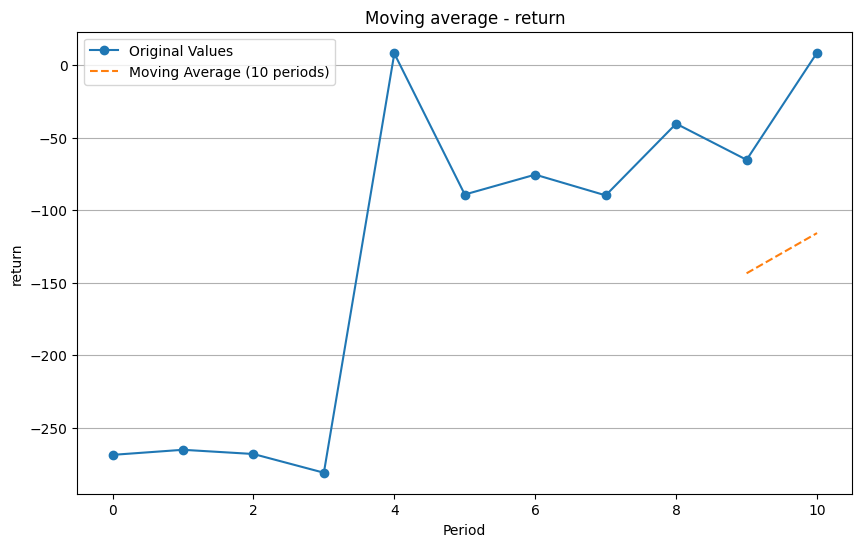

In [20]:
from resources import plot_moving_avg
plot_moving_avg('return', returns)

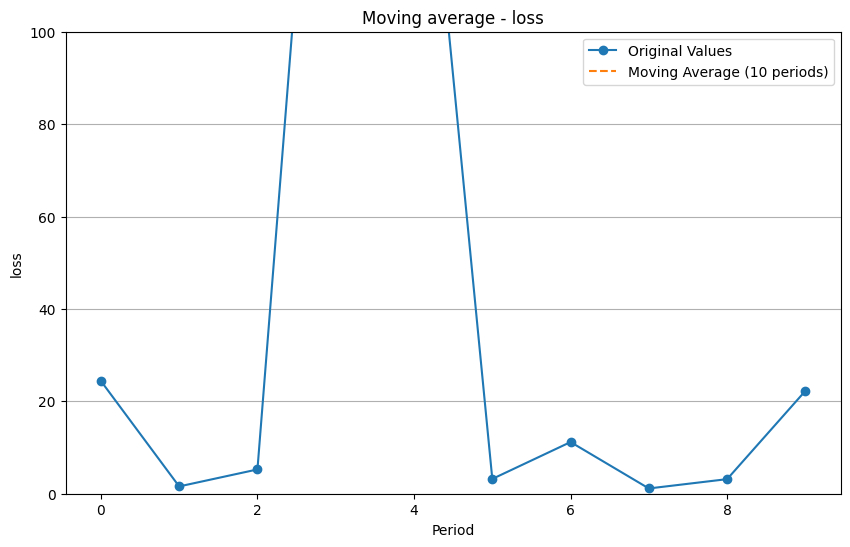

In [21]:
plot_moving_avg('loss', loss_log, ylim=True, top_lim=1_00)

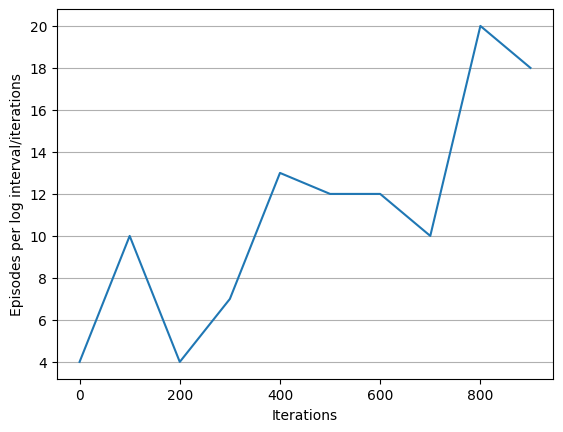

In [22]:
from resources import plot_metric_per_iteration
plot_metric_per_iteration(num_iterations, log_interval, episodes_per_log_interval, 'Episodes per log interval/iterations')

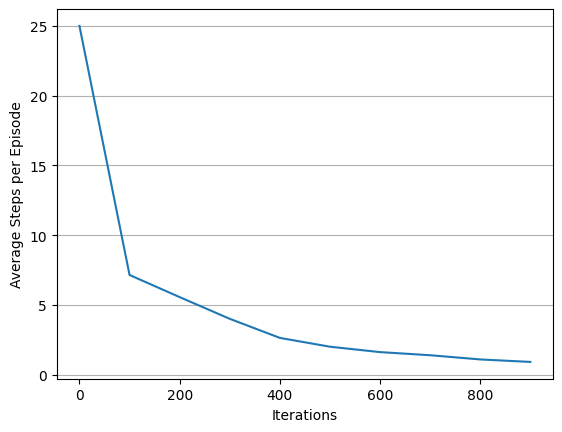

In [23]:
plot_metric_per_iteration(num_iterations, eval_interval, avg_steps_per_episode_per_eval_interval, 'Average Steps per Episode')

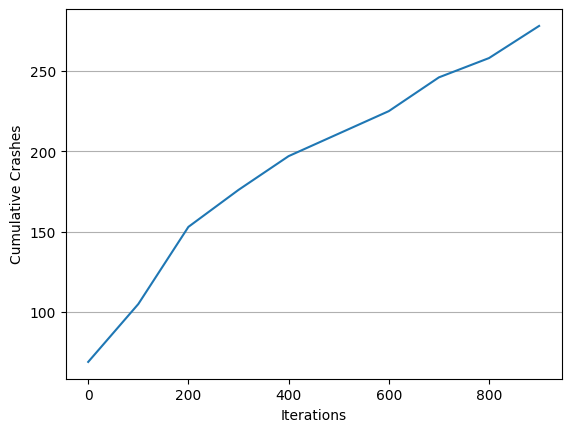

In [24]:
plot_metric_per_iteration(num_iterations, eval_interval, my_metric_log, 'Cumulative Crashes')

In [25]:
from resources import create_policy_eval_video

# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, "trained-agent", eval_env, eval_py_env)